In [3]:
import os
import json
import h5py
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.optim import Adam 
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from copy import deepcopy
import datetime
import tqdm

import imageio

import sys 
# sys.path.append("/home/ns1254/nn_project/gym-pusht/gym_pusht/envs/")
sys.path.append('/home/ns1254/diffusion_policy/') 
# from pusht import *

In [4]:
device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
dataset_path = "/home/ns1254/data_pusht/pusht_hf_206.hdf5" 
f = h5py.File(dataset_path, "r")
demos = list(f["data"].keys())
num_demos = len(demos)
print(f'Number of demos: {num_demos}')

Number of demos: 206


In [7]:
select_keys=['images'] 

In [8]:
actions_list=[]
obs_list=[]
for i,demo_id in enumerate(demos): 
    traj=f['data'][demo_id]

    # actions=traj['actions']
    actions = traj['dactions']
    select_obs=traj['obs']['images'] 
    select_obs=np.array(select_obs).transpose(0,3,1,2)
    actions_list.append(actions)
    obs_list.append(select_obs)
    
actions=np.concatenate(actions_list, axis=0)
states=np.concatenate(obs_list, axis=0)

actions.shape, states.shape

((25650, 2), (25650, 3, 96, 96))

In [9]:
np.min(actions, axis=0), np.max(actions, axis=0)

(array([-91., -78.]), array([135., 102.]))

In [10]:
actions = np.clip(actions, 0, 512)

np.min(actions, axis=0), np.max(actions, axis=0)

(array([0., 0.]), array([135., 102.]))

In [11]:
# max_action = 512
action_min=np.min(actions, axis=0)
action_max=np.max(actions, axis=0)

#convert to -1 to 1
actions = (actions - action_min) / (action_max - action_min) * 2 - 1

np.min(actions, axis=0), np.max(actions, axis=0)

(array([-1., -1.]), array([1., 1.]))

In [12]:
data_loader_train = DataLoader( list(zip(states, actions)), batch_size=64, shuffle=True) 

batch=next(iter(data_loader_train))
states,actions = batch
states.shape,actions.shape

(torch.Size([64, 3, 96, 96]), torch.Size([64, 2]))

In [13]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(8 * 48 * 48, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(-1, 8 * 48 * 48)
         
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.tanh(x)

In [11]:
learning_rate = 1e-4 

model = SimpleCNN().to(device)
criterion = nn.MSELoss() 
optimizer = Adam(model.parameters(), lr = learning_rate)

In [12]:
n_epoch = 600
losses=[] 
for itr in tqdm.tqdm(range(1, n_epoch+1)):
    model.train()
    train_loss = 0
    b=0
    for batch_states, batch_actions in data_loader_train: 
        batch_states = batch_states.to(device)
        batch_actions = batch_actions.to(device)
        y_pred = model(batch_states.float())
        loss   = criterion(y_pred, batch_actions.float()) 
        train_loss += loss.item() 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        b += 1   
    
    train_loss=train_loss/b
    losses.append(train_loss)
    
    if itr % (n_epoch//60) == 0:
        print(f'Epoch {itr} Train.Loss: {train_loss:.4f}')

  2%|▏         | 10/600 [00:15<13:56,  1.42s/it]

Epoch 10 Train.Loss: 0.0094


  3%|▎         | 20/600 [00:29<13:30,  1.40s/it]

Epoch 20 Train.Loss: 0.0081


  5%|▌         | 30/600 [00:43<13:17,  1.40s/it]

Epoch 30 Train.Loss: 0.0071


  7%|▋         | 40/600 [00:57<13:02,  1.40s/it]

Epoch 40 Train.Loss: 0.0062


  8%|▊         | 50/600 [01:11<12:48,  1.40s/it]

Epoch 50 Train.Loss: 0.0055


 10%|█         | 60/600 [01:25<12:36,  1.40s/it]

Epoch 60 Train.Loss: 0.0049


 12%|█▏        | 70/600 [01:39<12:19,  1.39s/it]

Epoch 70 Train.Loss: 0.0045


 13%|█▎        | 80/600 [01:53<12:07,  1.40s/it]

Epoch 80 Train.Loss: 0.0041


 15%|█▌        | 90/600 [02:07<11:55,  1.40s/it]

Epoch 90 Train.Loss: 0.0038


 17%|█▋        | 100/600 [02:21<11:39,  1.40s/it]

Epoch 100 Train.Loss: 0.0035


 18%|█▊        | 110/600 [02:35<11:24,  1.40s/it]

Epoch 110 Train.Loss: 0.0032


 20%|██        | 120/600 [02:49<11:11,  1.40s/it]

Epoch 120 Train.Loss: 0.0031


 22%|██▏       | 130/600 [03:03<10:55,  1.39s/it]

Epoch 130 Train.Loss: 0.0029


 23%|██▎       | 140/600 [03:17<10:43,  1.40s/it]

Epoch 140 Train.Loss: 0.0028


 25%|██▌       | 150/600 [03:31<10:29,  1.40s/it]

Epoch 150 Train.Loss: 0.0026


 27%|██▋       | 160/600 [03:45<10:15,  1.40s/it]

Epoch 160 Train.Loss: 0.0025


 28%|██▊       | 170/600 [03:59<10:00,  1.40s/it]

Epoch 170 Train.Loss: 0.0024


 30%|███       | 180/600 [04:13<09:47,  1.40s/it]

Epoch 180 Train.Loss: 0.0023


 32%|███▏      | 190/600 [04:27<09:43,  1.42s/it]

Epoch 190 Train.Loss: 0.0023


 33%|███▎      | 200/600 [04:41<09:19,  1.40s/it]

Epoch 200 Train.Loss: 0.0022


 35%|███▌      | 210/600 [04:55<09:06,  1.40s/it]

Epoch 210 Train.Loss: 0.0021


 37%|███▋      | 220/600 [05:09<08:51,  1.40s/it]

Epoch 220 Train.Loss: 0.0021


 38%|███▊      | 230/600 [05:23<08:40,  1.41s/it]

Epoch 230 Train.Loss: 0.0020


 40%|████      | 240/600 [05:37<08:20,  1.39s/it]

Epoch 240 Train.Loss: 0.0020


 42%|████▏     | 250/600 [05:51<08:09,  1.40s/it]

Epoch 250 Train.Loss: 0.0018


 43%|████▎     | 260/600 [06:05<07:54,  1.40s/it]

Epoch 260 Train.Loss: 0.0018


 45%|████▌     | 270/600 [06:19<07:41,  1.40s/it]

Epoch 270 Train.Loss: 0.0018


 47%|████▋     | 280/600 [06:33<07:28,  1.40s/it]

Epoch 280 Train.Loss: 0.0017


 48%|████▊     | 290/600 [06:47<07:13,  1.40s/it]

Epoch 290 Train.Loss: 0.0017


 50%|█████     | 300/600 [07:02<07:10,  1.43s/it]

Epoch 300 Train.Loss: 0.0016


 52%|█████▏    | 310/600 [07:16<06:45,  1.40s/it]

Epoch 310 Train.Loss: 0.0016


 53%|█████▎    | 320/600 [07:30<06:30,  1.39s/it]

Epoch 320 Train.Loss: 0.0016


 55%|█████▌    | 330/600 [07:44<06:20,  1.41s/it]

Epoch 330 Train.Loss: 0.0015


 57%|█████▋    | 340/600 [07:58<06:03,  1.40s/it]

Epoch 340 Train.Loss: 0.0015


 58%|█████▊    | 350/600 [08:12<05:48,  1.40s/it]

Epoch 350 Train.Loss: 0.0015


 60%|██████    | 360/600 [08:26<05:35,  1.40s/it]

Epoch 360 Train.Loss: 0.0014


 62%|██████▏   | 370/600 [08:41<05:53,  1.54s/it]

Epoch 370 Train.Loss: 0.0014


 63%|██████▎   | 380/600 [08:57<05:39,  1.54s/it]

Epoch 380 Train.Loss: 0.0014


 65%|██████▌   | 390/600 [09:12<05:23,  1.54s/it]

Epoch 390 Train.Loss: 0.0014


 67%|██████▋   | 400/600 [09:28<05:07,  1.54s/it]

Epoch 400 Train.Loss: 0.0013


 68%|██████▊   | 410/600 [09:43<04:53,  1.54s/it]

Epoch 410 Train.Loss: 0.0014


 70%|███████   | 420/600 [09:58<04:37,  1.54s/it]

Epoch 420 Train.Loss: 0.0014


 72%|███████▏  | 430/600 [10:14<04:21,  1.54s/it]

Epoch 430 Train.Loss: 0.0013


 73%|███████▎  | 440/600 [10:29<04:07,  1.54s/it]

Epoch 440 Train.Loss: 0.0013


 75%|███████▌  | 450/600 [10:45<03:50,  1.54s/it]

Epoch 450 Train.Loss: 0.0012


 77%|███████▋  | 460/600 [11:00<03:34,  1.53s/it]

Epoch 460 Train.Loss: 0.0013


 78%|███████▊  | 470/600 [11:15<03:19,  1.54s/it]

Epoch 470 Train.Loss: 0.0012


 80%|████████  | 480/600 [11:31<03:03,  1.53s/it]

Epoch 480 Train.Loss: 0.0012


 82%|████████▏ | 490/600 [11:46<02:48,  1.53s/it]

Epoch 490 Train.Loss: 0.0012


 83%|████████▎ | 500/600 [12:01<02:33,  1.54s/it]

Epoch 500 Train.Loss: 0.0012


 85%|████████▌ | 510/600 [12:17<02:18,  1.54s/it]

Epoch 510 Train.Loss: 0.0012


 87%|████████▋ | 520/600 [12:32<02:02,  1.53s/it]

Epoch 520 Train.Loss: 0.0012


 88%|████████▊ | 530/600 [12:47<01:39,  1.42s/it]

Epoch 530 Train.Loss: 0.0012


 90%|█████████ | 540/600 [13:02<01:31,  1.52s/it]

Epoch 540 Train.Loss: 0.0011


 92%|█████████▏| 550/600 [13:17<01:16,  1.54s/it]

Epoch 550 Train.Loss: 0.0011


 93%|█████████▎| 560/600 [13:32<01:01,  1.54s/it]

Epoch 560 Train.Loss: 0.0011


 95%|█████████▌| 570/600 [13:48<00:46,  1.54s/it]

Epoch 570 Train.Loss: 0.0011


 97%|█████████▋| 580/600 [14:03<00:30,  1.52s/it]

Epoch 580 Train.Loss: 0.0011


 98%|█████████▊| 590/600 [14:17<00:14,  1.40s/it]

Epoch 590 Train.Loss: 0.0011


100%|██████████| 600/600 [14:31<00:00,  1.45s/it]

Epoch 600 Train.Loss: 0.0011


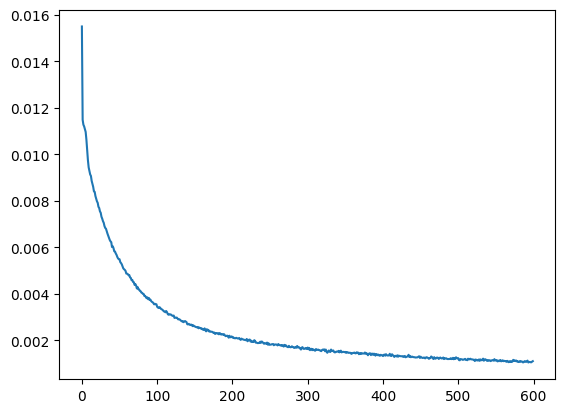

In [13]:
plt.plot(losses)

In [14]:
demo_id = demos[3]
traj=f['data'][demo_id]
actions=traj['dactions']
# states=traj['obs']['states']
select_obs=traj['obs']['images'] 
states=np.array(select_obs).transpose(0,3,1,2)
actions.shape, states.shape

((117, 2), (117, 3, 96, 96))

In [16]:
# model.eval()
# y_pred = model(batch_states.float()) 
# y_pred.shape, batch_states.shape

In [20]:
model.eval()
states_tensor = torch.tensor(states).float().to(device)
actions_pred = model(states_tensor).detach().cpu().numpy()

In [21]:
actions_pred = (actions_pred + 1) / 2 * (action_max - action_min) + action_min
np.min(actions_pred, axis=0), np.max(actions_pred, axis=0)

(array([1.57150626e-02, 3.03983688e-06]), array([35.12617841, 22.43085301]))

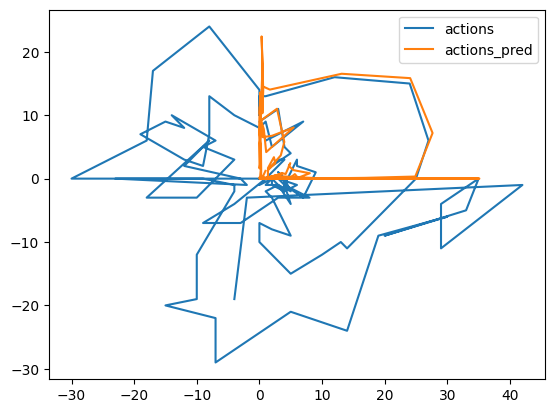

In [22]:
plt.plot(actions[:,0], actions[:,1], label='actions')
plt.plot(actions_pred[:,0], actions_pred[:,1], label='actions_pred')
plt.legend()
plt.show()

In [23]:
env=PushTEnv(obs_type="pixels")

state,info=env.reset()
ax,ay=info['pos_agent']
ax, ay

(279.0, 292.0)

In [28]:
state.shape

(96, 96, 3)

In [24]:
states_tensor = torch.tensor(state.transpose(2,0,1)[None,]).float().to(device)
actions_pred = model(states_tensor).detach().cpu().numpy()
actions_pred[0] 

array([-1., -1.], dtype=float32)

In [25]:
env.action_space

Box(0.0, 512.0, (2,), float32)

In [26]:
action_range=[env.action_space.low, env.action_space.high]
action_range

[array([0., 0.], dtype=float32), array([512., 512.], dtype=float32)]

In [27]:
env=PushTEnv(obs_type="pixels")

state,info=env.reset()

model.eval()
max_steps=1000
rewards=[]
rgbs=[]
for i in range(max_steps):
    states_tensor = torch.tensor(state.transpose(2,0,1)[None,]).float().to(device)
    actions_pred = model(states_tensor).detach().cpu().numpy()
    actions_pred = (actions_pred + 1) / 2 * (action_max - action_min) + action_min
    action=actions_pred[0] 
    state,reward,done,trunc,info=env.step(action)

     
    rgb=env.render()
    rgbs.append(rgb)
    rewards.append(reward)
    if done:
        break

print(f"Total reward: {sum(rewards)}")

Total reward: 379.5753024489263


In [29]:
imageio.mimsave('bc_pusht.mp4', rgbs, fps=30)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (680, 680) to (688, 688) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5e01e80] Warning: data is not aligned! This can lead to a speed loss


In [28]:
action

array([0., 0.])